# Machine Learning to Classify Insincere Quora Questions

**The aim is to be able to classify questions as sincere vs insincere using different features of the text and the question text itself. We will try Machine learning classification algorithms to solve the problem.**

In [1]:
import pandas as pd
import swifter
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
import sklearn.metrics as metrics


In [2]:
data = pd.read_csv('final_processed_df.csv')

In [3]:
data.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,2,0.027778,13,13,1.0000,0,1,0,0,quebec nationalist see province nation,38,5,1.894737,2.600000
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,1,0.012346,16,15,0.9375,0,1,1,0,adopt dog would encourage people adopt not shop,47,8,1.723404,2.000000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,2,0.029851,10,8,0.8000,0,2,0,0,velocity affect time velocity affect space geo...,51,7,1.313725,1.428571
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,4,0.070175,9,9,1.0000,0,1,0,0,otto von guericke use magdeburg hemisphere,42,6,1.357143,1.500000
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,3,0.038961,15,15,1.0000,0,1,0,0,convert montra helicon mountain bike change tyre,48,7,1.604167,2.142857


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 18 columns):
qid                      1306122 non-null object
question_text            1306122 non-null object
target                   1306122 non-null int64
length                   1306122 non-null int64
capitals                 1306122 non-null int64
caps_vs_length           1306122 non-null float64
num_words                1306122 non-null int64
num_unique_words         1306122 non-null int64
words_vs_unique          1306122 non-null float64
num_exclamation_marks    1306122 non-null int64
num_question_marks       1306122 non-null int64
num_punctuation          1306122 non-null int64
num_symbols              1306122 non-null int64
processed_text           1305749 non-null object
len_after                1306122 non-null int64
num_words_after          1306122 non-null int64
len_ratio                1306122 non-null float64
num_words_ratio          1306122 non-null float64
dtypes: floa

In [5]:
def float_to_int(x):
    if x == float('inf') or x == float('-inf'):
        return float(0) # or a large value you choose
    return int(x)

data.len_ratio = data.len_ratio.swifter.apply(float_to_int)
data.num_words_ratio = data.num_words_ratio.swifter.apply(float_to_int)

data.processed_text = data.processed_text.fillna('')

In [6]:
data.describe()

,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,len_after,num_words_after,len_ratio,num_words_ratio
count,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06
mean,6.187018e-02,7.067884e+01,2.860756e+00,4.557576e-02,1.280361e+01,1.213578e+01,9.666687e-01,1.742563e-03,1.057475e+00,2.904055e-01,1.543730e-02,4.271438e+01,6.453952e+00,1.206526e+00,1.660784e+00
std,2.409197e-01,3.878428e+01,2.573325e+00,3.919927e-02,7.052437e+00,6.040779e+00,5.687022e-02,4.676167e-02,2.588720e-01,7.637911e-01,1.502499e-01,2.517267e+01,3.730951e+00,5.222969e-01,6.736842e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.523810e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,1.000000e+00,2.000000e-02,8.000000e+00,8.000000e+00,9.354839e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,4.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,6.000000e+01,2.000000e+00,3.389831e-02,1.100000e+01,1.100000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.600000e+01,5.000000e+00,1.000000e+00,2.000000e+00
75%,0.000000e+00,8.500000e+01,4.000000e+00,5.882353e-02,1.500000e+01,1.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.300000e+01,8.000000e+00,1.000000e+00,2.000000e+00
max,1.000000e+00,1.017000e+03,1.800000e+02,1.000000e+00,1.340000e+02,9.600000e+01,1.000000e+00,5.000000e+00,1.000000e+01,3.500000e+01,2.000000e+01,6.840000e+02,6.900000e+01,8.100000e+01,2.800000e+01


In [7]:
sincere_df = data[data['target']==0]
insincere_df = data[data['target']==1]

In [8]:
sincere_df_subset = sincere_df.sample(n=160000)

In [9]:
insincere_df = insincere_df.reset_index()
sincere_df_subset = sincere_df_subset.reset_index()

In [10]:
sincere_df_subset.shape

(160000, 19)

In [11]:
subset = pd.concat([sincere_df_subset, insincere_df],0)
subset = subset.drop(['index'],1)
subset.head()

,qid,question_text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,processed_text,len_after,num_words_after,len_ratio,num_words_ratio
0,5ac62fd1a008d53a3fcf,Can hypnosis help me change some details on a ...,0,63,1,0.015873,13,13,1.000000,0,1,0,0,hypnosis help change detail time past,37,6,1.0,2.0
1,fbc1953919783efd640d,Why does cyclones spin clock wise in the sourt...,0,106,1,0.009434,15,13,0.866667,0,1,0,0,cyclone spin clock wise sourthernhemisphere an...,77,8,1.0,1.0
2,c12f98f80faea947d8a5,"To get better at anything you do, do you have ...",0,67,1,0.014925,13,11,0.846154,0,1,1,0,get well anything get uncomfortable,35,5,1.0,2.0
3,b1c1129198cbc04c5968,"Except for retirement, what are the reasons to...",0,63,1,0.015873,11,11,1.000000,0,1,1,0,except retirement reason save money,35,5,1.0,2.0
4,4920246317856d8814de,Why does talking about sex make some people fe...,0,63,1,0.015873,10,10,1.000000,0,1,0,0,talk sex make people feel uncomfortable,39,6,1.0,1.0


In [12]:
subset.shape

(240810, 18)

In [13]:
#split the data
X = subset.processed_text
y = subset.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168567,), (168567,), (72243,), (72243,))

## Logistic Regression

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

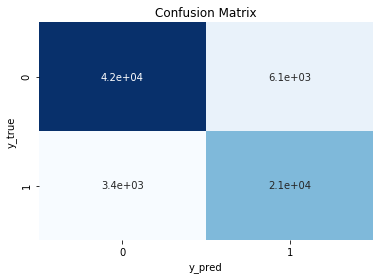

In [14]:
tf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
lr = LogisticRegression()
pipeline_lr = Pipeline([('tfidf', tf_vec), ('lr', lr)])
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90     48081
           1       0.77      0.86      0.81     24162

   micro avg       0.87      0.87      0.87     72243
   macro avg       0.85      0.87      0.86     72243
weighted avg       0.87      0.87      0.87     72243



In [16]:
y_prob = pipeline_lr.predict_proba(X_test)
from sklearn.metrics import f1_score
best_threshold = 0
f1=0
for i in np.arange(.1, .51, 0.01):
    y_pred = [1 if proba>i else 0 for proba in y_prob[:, 1]]
    f1score = f1_score(y_pred, y_test)
    if f1score>f1:
        best_threshold = i
        f1=f1score
        
y_pred = [1 if proba>best_threshold else 0 for proba in y_prob[:, 1]]
f1 = f1_score(y_test, y_pred)
print('The best threshold is {}, with an F1 score of {}'.format(best_threshold, f1))

The best threshold is 0.4999999999999998, with an F1 score of 0.8134085654950823


Text(0.5,0,'False Positive Rate')

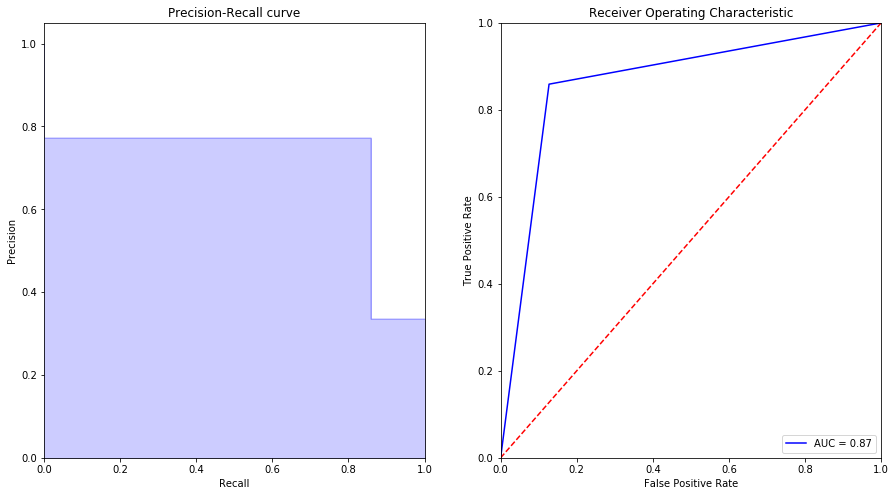

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

### Count vectorizer SVD

In [18]:
count_vec = CountVectorizer(stop_words='english', ngram_range=(1, 3))
svd = TruncatedSVD(n_components=100, random_state=6)
tf_vec = TfidfVectorizer(stop_words='english')

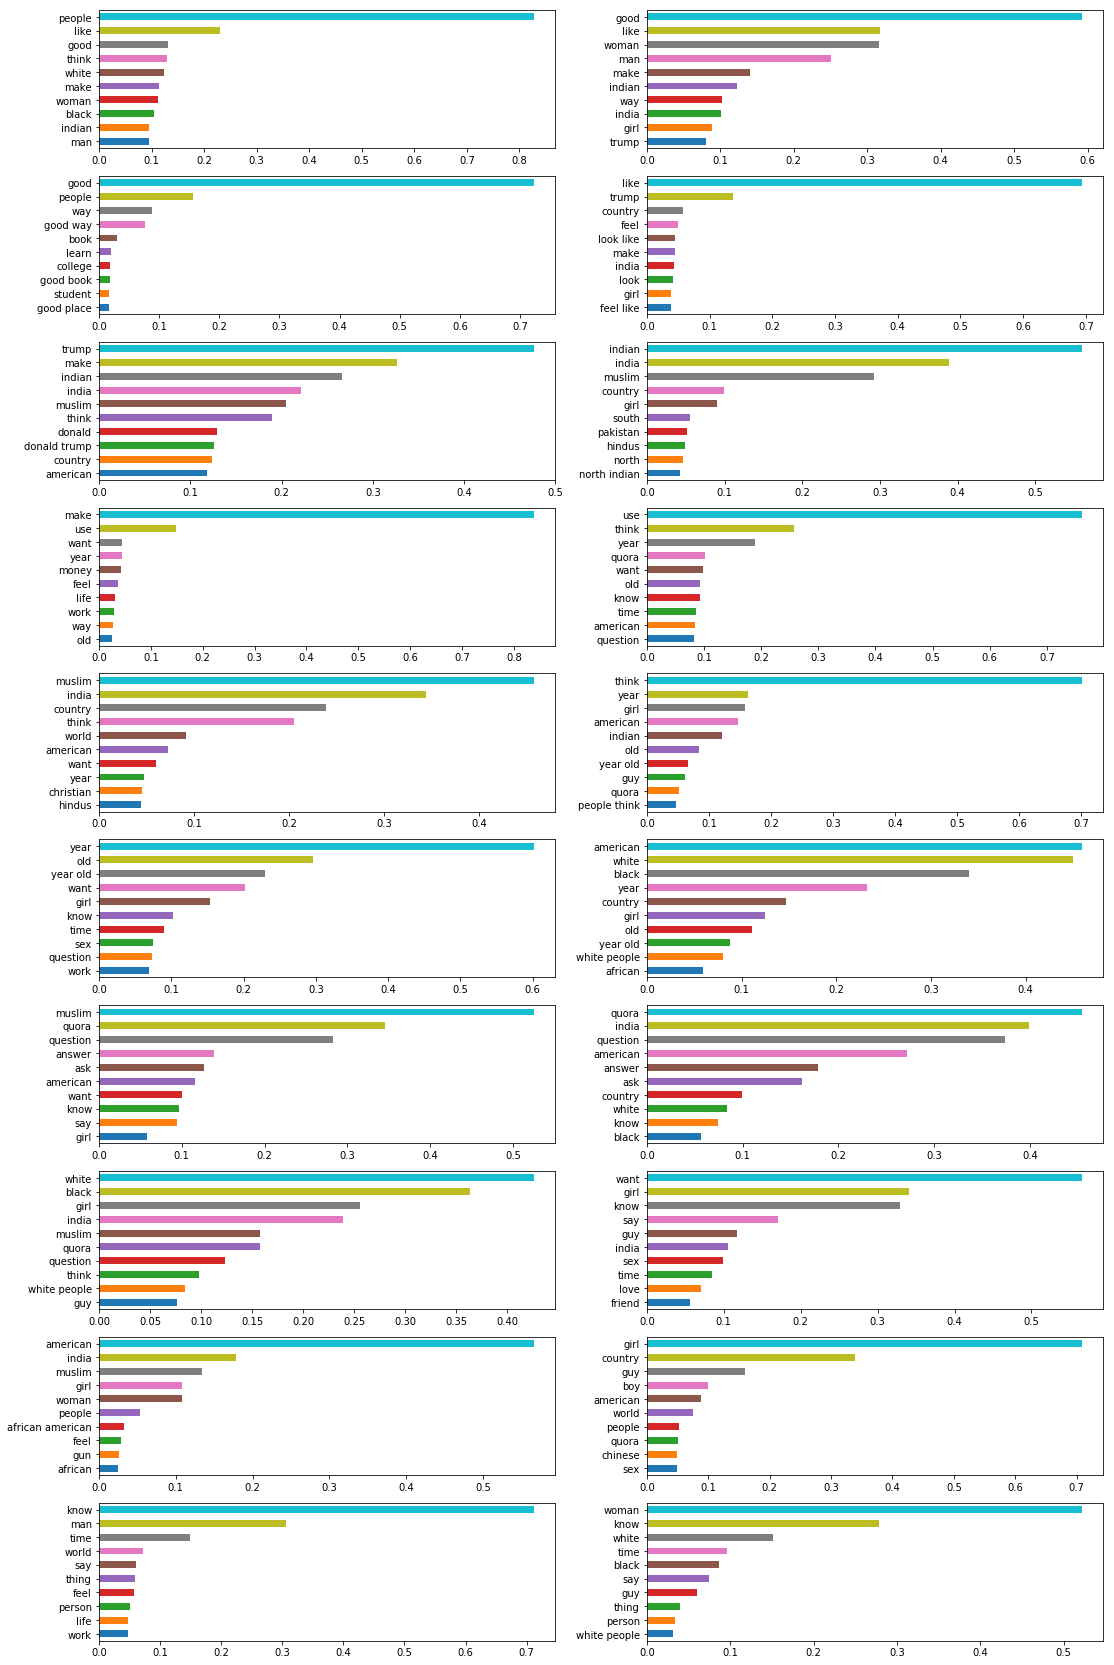

In [19]:
pipeline = Pipeline([('vectorizer', count_vec),('svd', svd)])
model = pipeline.fit_transform(X_train)

components = pd.DataFrame(data=svd.components_, columns=pipeline.named_steps['vectorizer'].get_feature_names())

fig, axes = plt.subplots(10, 2, figsize=(18, 30))
for i, ax in enumerate(axes.flat):
    components.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)
    

## Naive Bayes

In [20]:
mb = MultinomialNB()
pipeline_mb = Pipeline([ ('vectorizer', tf_vec), ('mb', mb)])

pipeline_mb.fit(X_train, y_train)
y_pred = pipeline_mb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,43457,4624
insincere,5709,18453


In [21]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     48081
           1       0.80      0.76      0.78     24162

   micro avg       0.86      0.86      0.86     72243
   macro avg       0.84      0.83      0.84     72243
weighted avg       0.86      0.86      0.86     72243



Text(0.5,0,'False Positive Rate')

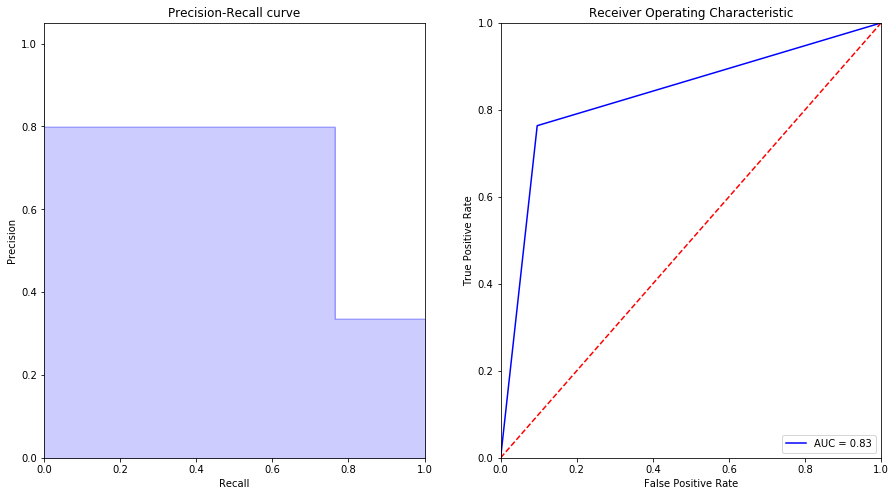

In [22]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## KNN

In [23]:
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([ ('vectorizer', tf_vec), ('mb', knn)])

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,46428,1653
insincere,18302,5860


In [24]:
score = cross_val_score(pipeline_mb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.97      0.82     48081
           1       0.78      0.24      0.37     24162

   micro avg       0.72      0.72      0.72     72243
   macro avg       0.75      0.60      0.60     72243
weighted avg       0.74      0.72      0.67     72243



Text(0.5,0,'False Positive Rate')

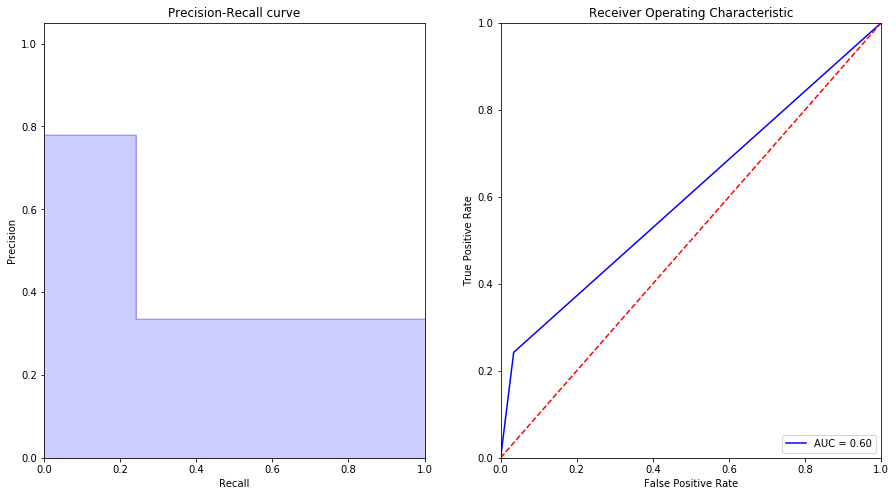

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## XGb

In [26]:
xgbc = xgb.XGBClassifier() 
pipeline_xgb = Pipeline([ ('vectorizer', tf_vec), ('mb', xgbc)])

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['sincere', 'insincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,insincere
sincere,46131,1950
insincere,12680,11482


In [27]:
score = cross_val_score(pipeline_xgb, X_test, y=y_test, cv=3, scoring='f1_macro')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86     48081
           1       0.85      0.48      0.61     24162

   micro avg       0.80      0.80      0.80     72243
   macro avg       0.82      0.72      0.74     72243
weighted avg       0.81      0.80      0.78     72243



Text(0.5,0,'False Positive Rate')

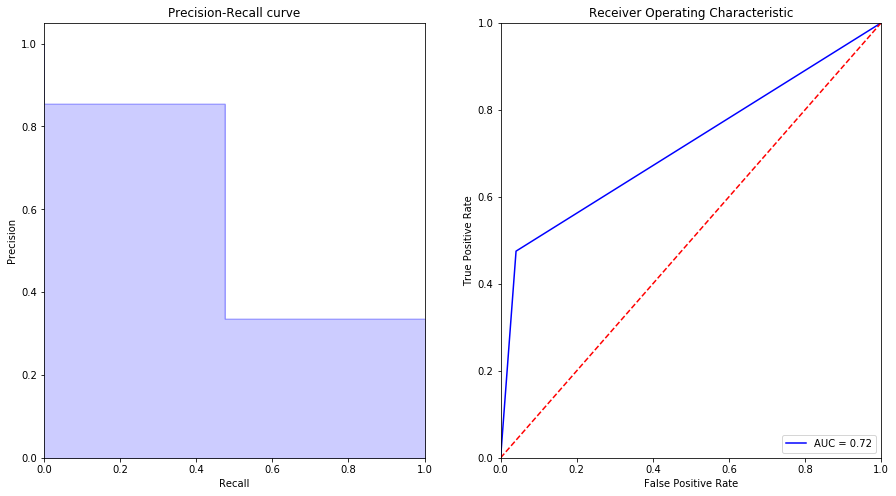

In [28]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

## Word2Vec

In [29]:
def text_preprocess(text):
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text) 
    text = re.sub(r'\s+', ' ', text)
    return text

q_text = subset.question_text.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:04<00:00, 58295.06it/s]


In [30]:
all_words = [nltk.word_tokenize(sent) for sent in q_text]

In [31]:
word2vec = Word2Vec(all_words, min_count=2)  
vocabulary = word2vec.wv.vocab

In [32]:
word2vec.wv.most_similar('toxic')

[('borderline', 0.7583668828010559),
 ('manipulative', 0.7579392194747925),
 ('passive', 0.7270898818969727),
 ('hurtful', 0.7119739055633545),
 ('egotistical', 0.7103731036186218),
 ('materialistic', 0.7026214599609375),
 ('unsatisfactory', 0.6978661417961121),
 ('loneliness', 0.6968875527381897),
 ('rhyme', 0.6961944103240967),
 ('abnormal', 0.6947051882743835)]

In [33]:
word2vec.wv.most_similar('insincere')

[('unanswered', 0.828280508518219),
 ('nonsensical', 0.8214545249938965),
 ('thinly', 0.8208191990852356),
 ('factual', 0.8206750154495239),
 ('idiotic', 0.8139907121658325),
 ('lame', 0.8119657635688782),
 ('upvote', 0.8069602251052856),
 ('anonymously', 0.8056206107139587),
 ('flagging', 0.8045205473899841),
 ('anonymous', 0.8027613759040833)]

In [34]:
word2vec.wv.most_similar('racist')

[('bigots', 0.6601197719573975),
 ('racists', 0.6496767997741699),
 ('racism', 0.6474902629852295),
 ('selfish', 0.6423566341400146),
 ('bigoted', 0.640907883644104),
 ('christian', 0.63759446144104),
 ('sexist', 0.6360123157501221),
 ('evil', 0.6342980265617371),
 ('hypocritical', 0.6287550926208496),
 ('hateful', 0.6236812472343445)]

In [81]:
wordvec=word2vec.wv

In [82]:
def word_averaging(wordvec, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wordvec.vocab:
            mean.append(wordvec.syn0norm[wordvec.vocab[word].index])
            all_words.add(wordvec.vocab[word].index)

    #if not mean:
       # logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
       # return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wordvec, text_list):
    return np.vstack([word_averaging(wordvec, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [74]:
word2vec_subset = subset[['question_text', 'target']]
word2vec_subset.question_text = word2vec_subset.question_text.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:03<00:00, 63468.93it/s]
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [75]:
train, test = train_test_split(word2vec_subset, test_size=0.3, random_state = 6)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['question_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['question_text']), axis=1).values

In [83]:
X_train_word_average = word_averaging_list(wordvec,train_tokenized)
X_test_word_average = word_averaging_list(wordvec,test_tokenized)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

## Logistic regression with all variables

In [35]:
subset_dropcols = subset.drop(['qid','question_text','target', 'processed_text'],1)

In [36]:
ngram = CountVectorizer(ngram_range=(3,3), max_df=0.50, min_df= 20)
ngram_matrix = ngram.fit_transform(subset.processed_text)

ngram_matrix = ngram_matrix.toarray()
vocab = ngram.get_feature_names()
ngram_df = pd.DataFrame(ngram_matrix, columns=vocab)

In [37]:
ngram_df=ngram_df.reset_index()
subset_dropcols =subset_dropcols.reset_index()
subset_ngram = pd.concat([subset_dropcols, ngram_df], 1)

In [38]:
subset_ngram = subset_ngram.drop(['index'],1)
subset_ngram.head()

,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,...,would world like,year old boy,year old daughter,year old girl,year old guy,year old male,year old man,year old son,year old woman,yearold girl bore
0,63,1,0.015873,13,13,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,106,1,0.009434,15,13,0.866667,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,1,0.014925,13,11,0.846154,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,63,1,0.015873,11,11,1.000000,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,63,1,0.015873,10,10,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X = subset_ngram
y = subset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5,1,'Confusion Matrix')

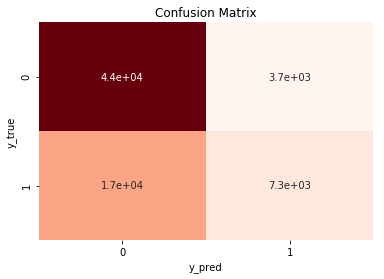

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Reds', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     48081
           1       0.66      0.30      0.42     24162

   micro avg       0.72      0.72      0.72     72243
   macro avg       0.69      0.61      0.61     72243
weighted avg       0.70      0.72      0.68     72243



Text(0.5,0,'False Positive Rate')

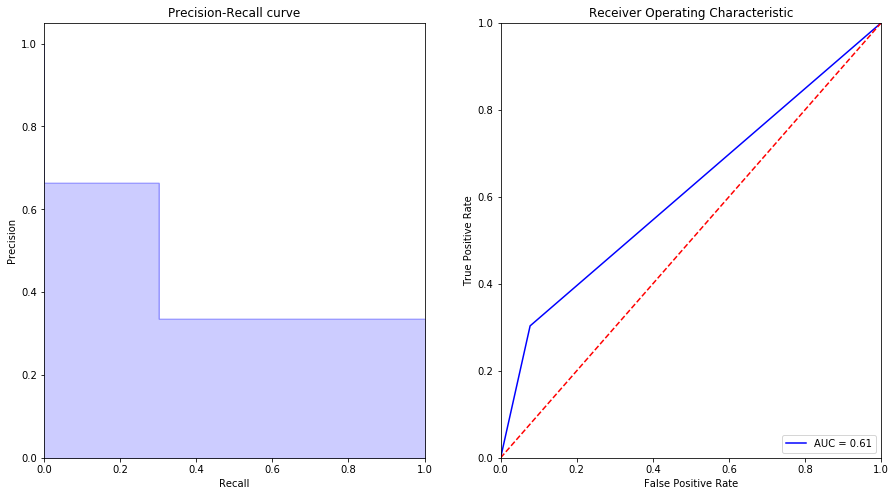

In [42]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

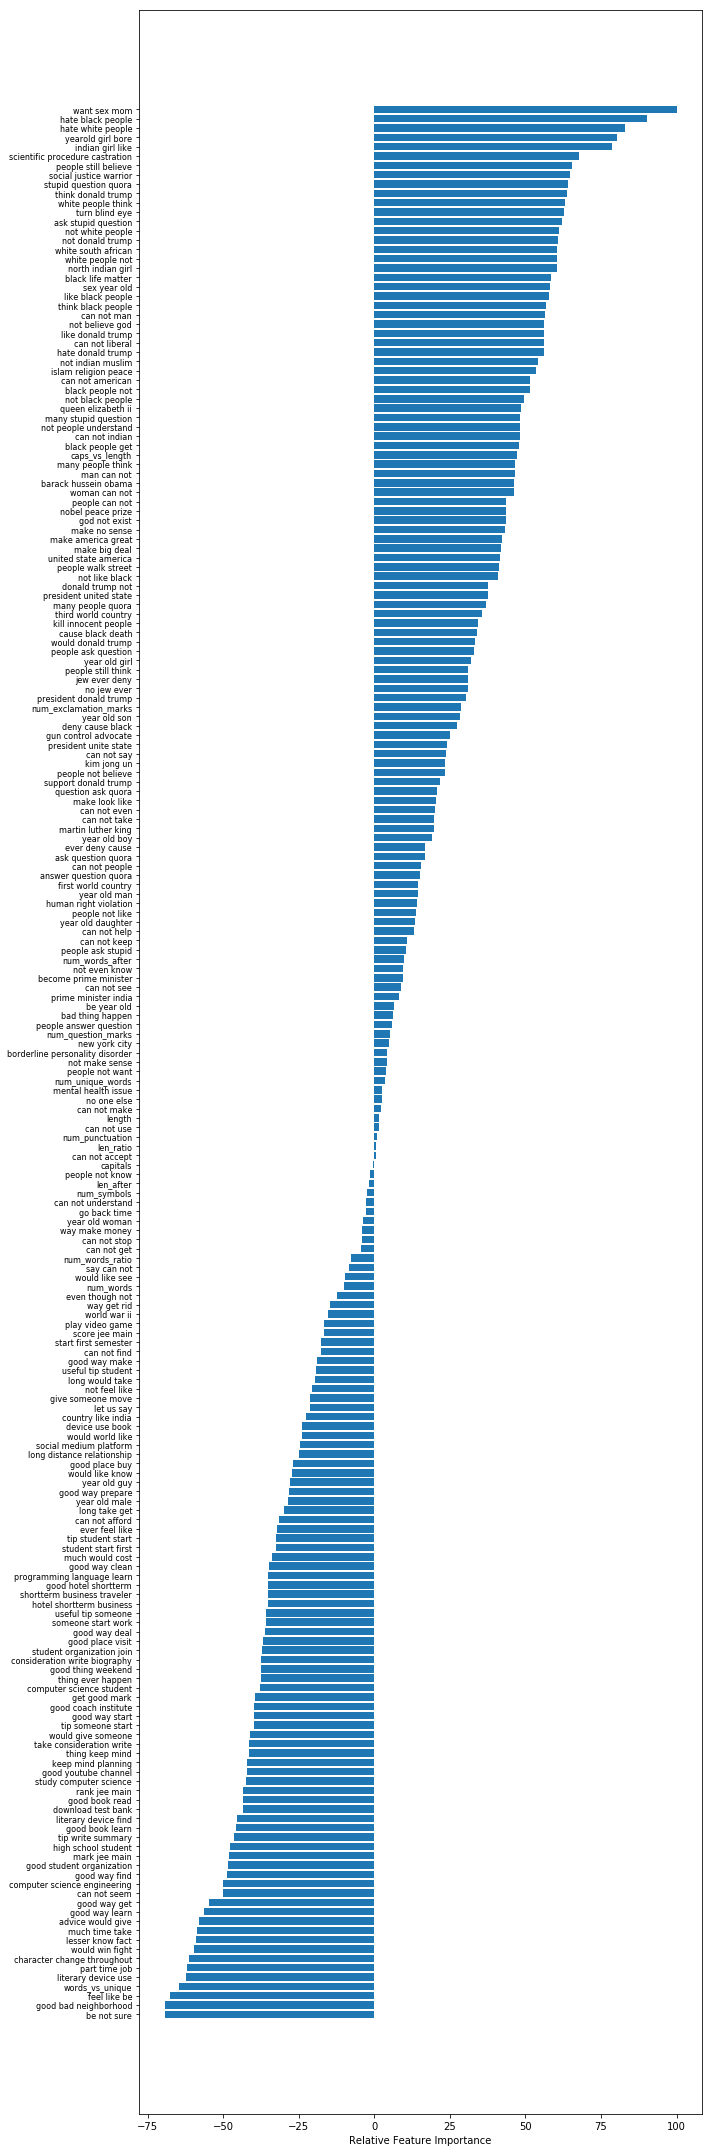

In [43]:
feature_importance = (lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

# Deep Learning

In [44]:
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential, Model # initialize neural network library
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate # build our layers library
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [45]:
X = subset.question_text
y = subset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((168567,), (168567,), (72243,), (72243,))

In [46]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


In [47]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [49]:
def simple_nn_model():
    model = Sequential() # initialize neural network
    model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
model = simple_nn_model()

Instructions for updating:
Colocations handled automatically by placer.


In [50]:
model.fit(X_train, y_train)
pred_noemb_test_y = model.predict(X_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
168567/168567 [==============================] - 9s 51us/step - loss: 0.6115 - acc: 0.6731


In [51]:
#y_pred_val = (pred_noemb_val_y > 0.5).astype(int)
y_pred_test = (pred_noemb_test_y > 0.5).astype(int)
# Print predict using f1score from sklearn


In [52]:
from sklearn.metrics import accuracy_score

In [53]:
score = accuracy_score(y_test, y_pred_test)
print(score)

0.6785294076934789


In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [55]:
print(f1_score(y_test, y_pred_test, average="macro"))
print(precision_score(y_test, y_pred_test, average="macro"))
print(recall_score(y_test, y_pred_test, average="macro")) 

0.49716425782926
0.6419535729662653
0.5387437778502109


Text(0.5,1,'Confusion Matrix')

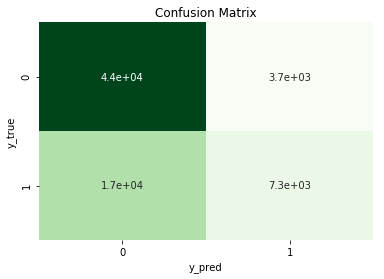

In [56]:
cm = confusion_matrix(y_test, y_pred)

ax = plt.gca()
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')
ax.set_title('Confusion Matrix')

Text(0.5,0,'False Positive Rate')

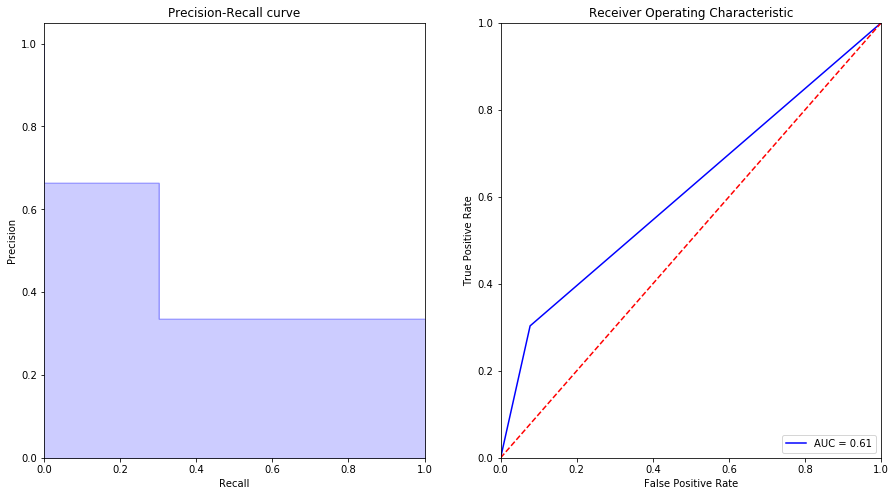

In [57]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

ax1.step(recall, precision, color='b', alpha=0.2,where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('Precision-Recall curve')

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

ax2.set_title('Receiver Operating Characteristic')
ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

In [91]:
lstm_subset = subset[['question_text','target']]

In [92]:
lstm_subset.question_text = lstm_subset.question_text.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:03<00:00, 62245.17it/s]
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [93]:
train, test = train_test_split(lstm_subset, test_size=0.3, random_state = 6)

In [94]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(train.question_text)
sequences = tokenizer.texts_to_sequences(train.question_text)
data = pad_sequences(sequences, maxlen=50)

In [97]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

In [100]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
model.fit(data, train.target, validation_split=0.3, epochs=1)

Train on 117996 samples, validate on 50571 samples
Epoch 1/1
117996/117996 [==============================] - 233s 2ms/step - loss: 0.3201 - acc: 0.8692 - val_loss: 0.2967 - val_acc: 0.8812


In [112]:
word2vec_subset = subset[['question_text','target']]

In [113]:
word2vec_subset.question_text = word2vec_subset.question_text.swifter.apply(text_preprocess)

Pandas Apply: 100%|██████████| 240810/240810 [00:04<00:00, 58599.27it/s]
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [123]:
train, test = train_test_split(word2vec_subset, test_size=0.3, random_state = 6)

In [147]:
from tqdm import tqdm
from nltk.tokenize import WordPunctTokenizer


In [155]:
def text_to_wordlist(text, lower=False):
    
    # Tokenize
    text = nltk.word_tokenize(text)
    
    vocab.append(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

In [156]:
comments = process_comments(word2vec_subset.question_text)


100%|██████████| 240810/240810 [00:32<00:00, 7453.76it/s]


In [157]:
model = Word2Vec(comments)


In [158]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 21504


In [159]:
word_vectors.vocab

{'can': <gensim.models.keyedvectors.Vocab at 0x1ca33ddef0>,
 'hypnosis': <gensim.models.keyedvectors.Vocab at 0x1ca33ddfd0>,
 'help': <gensim.models.keyedvectors.Vocab at 0x1ca33ddf28>,
 'me': <gensim.models.keyedvectors.Vocab at 0x1ca33ddf60>,
 'change': <gensim.models.keyedvectors.Vocab at 0x1c68db3400>,
 'some': <gensim.models.keyedvectors.Vocab at 0x1c68db3cc0>,
 'details': <gensim.models.keyedvectors.Vocab at 0x1ca33e9048>,
 'on': <gensim.models.keyedvectors.Vocab at 0x1ca33e9080>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1ca33e90b8>,
 'time': <gensim.models.keyedvectors.Vocab at 0x1ca33e90f0>,
 'in': <gensim.models.keyedvectors.Vocab at 0x1ca33e9128>,
 'the': <gensim.models.keyedvectors.Vocab at 0x1ca33e9160>,
 'past': <gensim.models.keyedvectors.Vocab at 0x1ca33e9198>,
 'why': <gensim.models.keyedvectors.Vocab at 0x1ca33e91d0>,
 'does': <gensim.models.keyedvectors.Vocab at 0x1ca33e9208>,
 'cyclones': <gensim.models.keyedvectors.Vocab at 0x1ca33e9240>,
 'spin': <gensim.models

In [161]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))


Number of word vectors: 21504


In [162]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [ ]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

In [ ]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass        

In [ ]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization